#  Standard Test Stat Distribution Demo
StandardTestStatDistributionDemo.C

This simple script plots the sampling distribution of the profile likelihood
ratio test statistic based on the input Model File.  To do this one needs to
specify the value of the parameter of interest that will be used for evaluating
the test statistic and the value of the parameters used for generating the toy data.
In this case, it uses the upper-limit estimated from the ProfileLikleihoodCalculator,
which assumes the asymptotic chi-square distribution for -2 log profile likelihood ratio.
Thus, the script is handy for checking to see if the asymptotic approximations are valid.
To aid, that comparison, the script overlays a chi-square distribution as well.
The most common parameter of interest is a parameter proportional to the signal rate,
and often that has a lower-limit of 0, which breaks the standard chi-square distribution.
Thus the script allows the parameter to be negative so that the overlay chi-square is
the correct asymptotic distribution.




**Author:** Kyle Cranmer  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:31 AM.</small></i>

In [1]:
%%cpp -d
#include "TFile.h"
#include "TROOT.h"
#include "TH1F.h"
#include "TCanvas.h"
#include "TSystem.h"
#include "TF1.h"
#include "TSystem.h"

#include "RooWorkspace.h"
#include "RooAbsData.h"

#include "RooStats/ModelConfig.h"
#include "RooStats/FeldmanCousins.h"
#include "RooStats/ToyMCSampler.h"
#include "RooStats/PointSetInterval.h"
#include "RooStats/ConfidenceBelt.h"

#include "RooStats/ProfileLikelihoodCalculator.h"
#include "RooStats/LikelihoodInterval.h"
#include "RooStats/ProfileLikelihoodTestStat.h"
#include "RooStats/SamplingDistribution.h"
#include "RooStats/SamplingDistPlot.h"

In [2]:
%%cpp -d
// This is a workaround to make sure the namespace is used inside functions
using namespace RooFit;
using namespace RooStats;

In [3]:
bool useProof = false; // flag to control whether to use Proof
int nworkers = 0;      // number of workers (default use all available cores)

-------------------------------------------------------
 The actual macro

 Arguments are defined. 

In [4]:
const char *infile = "";
const char *workspaceName = "combined";
const char *modelConfigName = "ModelConfig";
const char *dataName = "obsData";

The number of toy mc used to generate the distribution

In [5]:
int nToyMC = 1000;

The parameter below is needed for asymptotic distribution to be chi-square,
 but set to false if your model is not numerically stable if mu<0

In [6]:
bool allowNegativeMu = true;

-------------------------------------------------------
 First part is just to access a user-defined file
 or create the standard example file if it doesn't exist

In [7]:
const char *filename = "";
if (!strcmp(infile, "")) {
   filename = "results/example_combined_GaussExample_model.root";
   bool fileExist = !gSystem->AccessPathName(filename); // note opposite return code
   // if file does not exists generate with histfactory
   if (!fileExist) {
#ifdef _WIN32
      cout << "HistFactory file cannot be generated on Windows - exit" << endl;
      return;
#endif
      // Normally this would be run on the command line
      cout << "will run standard hist2workspace example" << endl;
      gROOT->ProcessLine(".! prepareHistFactory .");
      gROOT->ProcessLine(".! hist2workspace config/example.xml");
      cout << "\n\n---------------------" << endl;
      cout << "Done creating example input" << endl;
      cout << "---------------------\n\n" << endl;
   }

} else
   filename = infile;

Try to open the file

In [8]:
TFile *file = TFile::Open(filename);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



If input file was specified byt not found, quit

In [9]:
if (!file) {
   cout << "StandardRooStatsDemoMacro: Input file " << filename << " is not found" << endl;
   return;
}

-------------------------------------------------------
 Now get the data and workspace

Get the workspace out of the file

In [10]:
RooWorkspace *w = (RooWorkspace *)file->Get(workspaceName);
if (!w) {
   cout << "workspace not found" << endl;
   return;
}

Get the modelconfig out of the file

In [11]:
ModelConfig *mc = (ModelConfig *)w->obj(modelConfigName);

Get the modelconfig out of the file

In [12]:
RooAbsData *data = w->data(dataName);

Make sure ingredients are found

In [13]:
if (!data || !mc) {
   w->Print();
   cout << "data or ModelConfig was not found" << endl;
   return;
}

mc->Print();


=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (obs_x_channel1,weightVar,channelCat)
Parameters of Interest:  RooArgSet:: = (SigXsecOverSM)
Nuisance Parameters:     RooArgSet:: = (alpha_syst2,alpha_syst3,gamma_stat_channel1_bin_0,gamma_stat_channel1_bin_1)
Global Observables:      RooArgSet:: = (nom_alpha_syst2,nom_alpha_syst3,nom_gamma_stat_channel1_bin_0,nom_gamma_stat_channel1_bin_1)
PDF:                     RooSimultaneous::simPdf[ indexCat=channelCat channel1=model_channel1 ] = 0.174888



-------------------------------------------------------
 Now find the upper limit based on the asymptotic results

In [14]:
RooRealVar *firstPOI = (RooRealVar *)mc->GetParametersOfInterest()->first();
ProfileLikelihoodCalculator plc(*data, *mc);
LikelihoodInterval *interval = plc.GetInterval();
double plcUpperLimit = interval->UpperLimit(*firstPOI);
delete interval;
cout << "\n\n--------------------------------------" << endl;
cout << "Will generate sampling distribution at " << firstPOI->GetName() << " = " << plcUpperLimit << endl;
int nPOI = mc->GetParametersOfInterest()->getSize();
if (nPOI > 1) {
   cout << "not sure what to do with other parameters of interest, but here are their values" << endl;
   mc->GetParametersOfInterest()->Print("v");
}

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- createNLL: caching constraint set under name CONSTR_OF_PDF_simPdf_FOR_OBS_channelCat:obs_x_channel1 with 4 entries
[#1] INFO:Minization --  Including the following contraint terms in minimization: (alpha_syst2Constraint,alpha_syst3Constraint,gamma_stat_channel1_bin_0_constraint,gamma_stat_channel1_bin_1_constraint)
[#1] INFO:Minization -- The following global observables have been defined: (nom_alpha_syst2,nom_alpha_syst3,nom_gamma_stat_channel1_bin_0,nom_gamma_stat_channel1_bin_1)
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoGLobalFit - find MLE 
[#0] PROGRESS:Minization -- ProfileLikelihoodCalcultor::DoMinimizeNLL - using Minuit / Migrad with strategy 1
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_simPdf_obsData_with_constr) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minization -- RooMinimizer::optimizeConst: ac

-------------------------------------------------------
 create the test stat sampler

In [15]:
ProfileLikelihoodTestStat ts(*mc->GetPdf());

To avoid effects from boundary and simplify asymptotic comparison, set min=-max

In [16]:
if (allowNegativeMu)
   firstPOI->setMin(-1 * firstPOI->getMax());

Temporary rooargset

In [17]:
RooArgSet poi;
poi.add(*mc->GetParametersOfInterest());

Create and configure the toymcsampler

In [18]:
ToyMCSampler sampler(ts, nToyMC);
sampler.SetPdf(*mc->GetPdf());
sampler.SetObservables(*mc->GetObservables());
sampler.SetGlobalObservables(*mc->GetGlobalObservables());
if (!mc->GetPdf()->canBeExtended() && (data->numEntries() == 1)) {
   cout << "tell it to use 1 event" << endl;
   sampler.SetNEventsPerToy(1);
}
firstPOI->setVal(plcUpperLimit);                                  // set POI value for generation
sampler.SetParametersForTestStat(*mc->GetParametersOfInterest()); // set POI value for evaluation

if (useProof) {
   ProofConfig pc(*w, nworkers, "", false);
   sampler.SetProofConfig(&pc); // enable proof
}

firstPOI->setVal(plcUpperLimit);
RooArgSet allParameters;
allParameters.add(*mc->GetParametersOfInterest());
allParameters.add(*mc->GetNuisanceParameters());
allParameters.Print("v");

SamplingDistribution *sampDist = sampler.GetSamplingDistribution(allParameters);
SamplingDistPlot plot;
plot.AddSamplingDistribution(sampDist);
plot.GetTH1F(sampDist)->GetYaxis()->SetTitle(
   Form("f(-log #lambda(#mu=%.2f) | #mu=%.2f)", plcUpperLimit, plcUpperLimit));
plot.SetAxisTitle(Form("-log #lambda(#mu=%.2f)", plcUpperLimit));

TCanvas *c1 = new TCanvas("c1");
c1->SetLogy();
plot.Draw();
double min = plot.GetTH1F(sampDist)->GetXaxis()->GetXmin();
double max = plot.GetTH1F(sampDist)->GetXaxis()->GetXmax();

TF1 *f = new TF1("f", Form("2*ROOT::Math::chisquared_pdf(2*x,%d,0)", nPOI), min, max);
f->Draw("same");
c1->SaveAs("standard_test_stat_distribution.pdf");

  1) 0x7f1190ca6460 RooRealVar::             SigXsecOverSM = 2.32744 +/- 0.586082  L(-3 - 3)  "SigXsecOverSM"
  2) 0x7f1190ca2bd0 RooRealVar::               alpha_syst2 = 0.710796 +/- 0.982182  L(-5 - 5)  "alpha_syst2"
  3) 0x7f1190ca9a90 RooRealVar::               alpha_syst3 = 0.260222 +/- 0.947589  L(-5 - 5)  "alpha_syst3"
  4) 0x7f11900317b0 RooRealVar:: gamma_stat_channel1_bin_0 = 1.03668 +/- 0.0493173  L(0 - 1.25)  "gamma_stat_channel1_bin_0"
  5) 0x7f11900c3c30 RooRealVar:: gamma_stat_channel1_bin_1 = 1.05157 +/- 0.080065  L(0 - 1.5)  "gamma_stat_channel1_bin_1"
[#0] PROGRESS:Generation -- generated toys: 500 / 1000


Info in <TCanvas::Print>: pdf file standard_test_stat_distribution.pdf has been created


Draw all canvases 

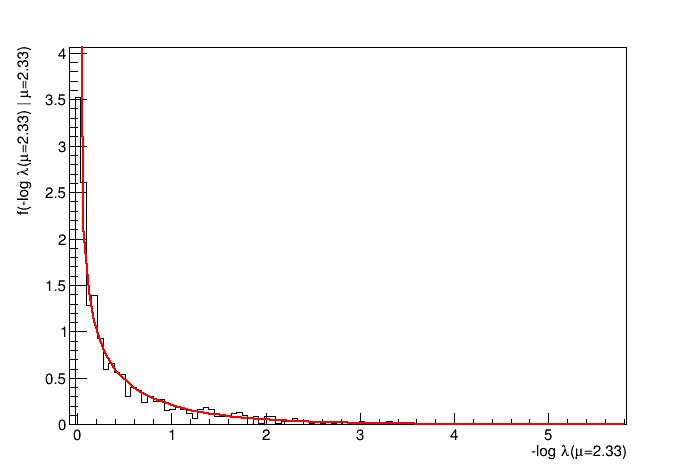

In [19]:
gROOT->GetListOfCanvases()->Draw()